# Autoencoder

**Disclaimer: The autoencoder is a work in progress, stability and results are not guaranteed.**

Ontime offers an implementation of an autoencoder made specifically for anomaly detection in periodic time series. 
The autoencoder is trained to compress and reconstruct signals. The reconstruction can then be used for anomaly detection.
The way it detects anomalies is by evaluating the error between the reconstructed signal and the original; since it learned the "usual" shape of the signal, the error should be significantly higher in case of anomaly.

This notebook shows how to parameter and use ontime's autoencoder through an example of training, testing and anomaly detection.

In [1]:
# Import to be able to import python package from src
import sys
sys.path.insert(0, '../../../../src')

from ontime.core.time_series.time_series import TimeSeries
from ontime.core.model.models.autoencoder import Autoencoder
from ontime.module.data.sliced_dataset import SlicedDataset
import torch.utils
import darts
from colorutils import Color
import matplotlib.pyplot as plt
import pandas as pd

## Preparing data
The autoencoder will be able to train on any dataset with periodic data that can be put in TimeSeries format. Here we will use one of the datasets provided by the Dataset class.

component,Sunspots
Month,
1749-01-01,58.0
1749-02-01,62.6
1749-03-01,70.0
1749-04-01,55.7
1749-05-01,85.0


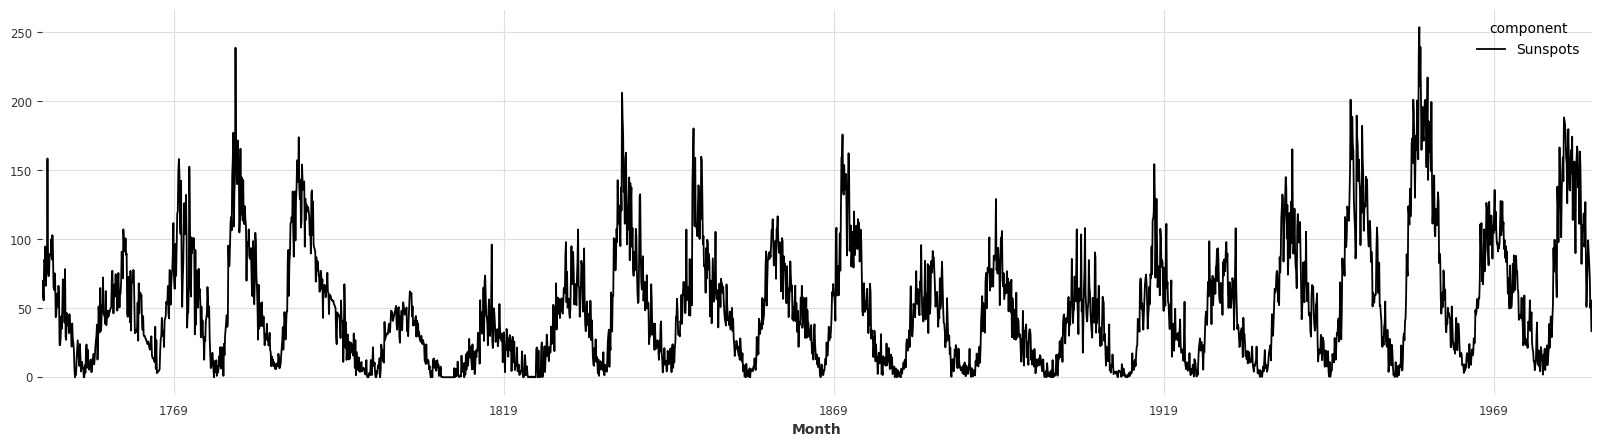

In [2]:
from ontime.module.data.dataset import Dataset

data = Dataset.SunspotsDataset.load()

#subset = data.columns.tolist()[:3] # for the sake of this guide, we will use a subset of the available features
#data = data[subset]
data.pd_dataframe().plot(figsize=(20, 5))
data.pd_dataframe().head()

### Period of the signal
Ontime does not provide any period detection tool, but here is an example using the periodicity_detection package. 

In [3]:
import periodicity_detection as pyd

def get_period(data):
    periods = []
    for col in data.columns:
        periods.append(pyd.findfrequency(data.pd_dataframe()[col].to_numpy(), detrend=True))
        
    return max(periods)

print(get_period(data))

125


In [4]:
period = 125 # Since the period is very small, we will take a multiple of it as a base

### Data format
The autoencoder uses a particular data format available as a SlicedDataset.
We will use a common train/test method for this example.

In [5]:
from ontime.module.processing.common import train_test_split
train, test = train_test_split(data, train_split = 0.75)

tdataset = SlicedDataset(train, period)
print(tdataset)

The autoencoder uses pytorch's DataLoader during the training phase. The batch size can be adjusted as you wish.

In [6]:
tdata = torch.utils.data.DataLoader(
            tdataset,
            batch_size=100,
            shuffle=False)

## Preparing the autoencoder
The autoencoder is made from an Encoder and a Decoder with symmetrical structures.

An autoencoder needs to be parametrized depending on the dataset it will be trained on. Namely, the number of entry dimensions is the number of features times the length of the period. The number of output dimensions is the same as entry.

Since one sample is a data slice of period length, and the error is computed by sample, we can only detect anomalies over a window of period length.

Now, the period given to the SlicedDataset can be any multiple of the actual period. Giving the autoencoder a smaller window will make the detection more precise, but it also makes detecting patterns more difficult.


As for the latent space, its size is freely determined by the user.


In [7]:
columns = train.columns.tolist()
input_dimensions = len(columns) * period #we give (period) samples at once, meaning the AE receives nb features * period data points at once
latent_dimensions = input_dimensions//6 # an arbitrary value, can be anything smaller that input_dimensions

The implementation is based on pytorch, which offers to run the code on GPU if available. As of now, only running on CPU is supported.

In [8]:
autoencoder = Autoencoder(input_dimensions, latent_dimensions)
device = 'cpu'
autoencoder = autoencoder.to(device)

In [9]:
print(autoencoder)

Encoder: 2 layers
                layer 0: 125 -> 72
                layer 1: 72 -> 20
                
Decoder: 2 layers
                layer 0: 20 -> 72
                layer 1: 72 -> 125
                


Alternatively, Autoencoder offers a class method that will automatically create a new Autoencoder with the correct entry dimensions. This Autoencoder's latent space will have (entry dimensions)/4 dimensions.

In [10]:
autoencoder = Autoencoder.new_encoder_for_dataset(train, period)
print(autoencoder)

Encoder: 2 layers
                layer 0: 125 -> 78
                layer 1: 78 -> 31
                
Decoder: 2 layers
                layer 0: 31 -> 78
                layer 1: 78 -> 125
                


## Training
Training is done by invoking the method train().

In [11]:
autoencoder.train(tdata, device, epochs = 100)

epoch 1/100
1/1
epoch 2/100
1/1
epoch 3/100
1/1
epoch 4/100
1/1
epoch 5/100
1/1
epoch 6/100
1/1
epoch 7/100
1/1
epoch 8/100
1/1
epoch 9/100
1/1
epoch 10/100
1/1
epoch 11/100
1/1
epoch 12/100
1/1
epoch 13/100
1/1
epoch 14/100
1/1
epoch 15/100
1/1
epoch 16/100
1/1
epoch 17/100
1/1
epoch 18/100
1/1
epoch 19/100
1/1
epoch 20/100
1/1
epoch 21/100
1/1
epoch 22/100
1/1
epoch 23/100
1/1
epoch 24/100
1/1
epoch 25/100
1/1
epoch 26/100
1/1
epoch 27/100
1/1
epoch 28/100
1/1
epoch 29/100
1/1
epoch 30/100
1/1
epoch 31/100
1/1
epoch 32/100
1/1
epoch 33/100
1/1
epoch 34/100
1/1
epoch 35/100
1/1
epoch 36/100
1/1
epoch 37/100
1/1
epoch 38/100
1/1
epoch 39/100
1/1
epoch 40/100
1/1
epoch 41/100
1/1
epoch 42/100
1/1
epoch 43/100
1/1
epoch 44/100
1/1
epoch 45/100
1/1
epoch 46/100
1/1
epoch 47/100
1/1
epoch 48/100
1/1
epoch 49/100
1/1
epoch 50/100
1/1
epoch 51/100
1/1
epoch 52/100
1/1
epoch 53/100
1/1
epoch 54/100
1/1
epoch 55/100
1/1
epoch 56/100
1/1
epoch 57/100
1/1
epoch 58/100
1/1
epoch 59/100
1/1
epoch 

The method get_reconstructed() returns a reconstructed version of the signal given as parameter as a TimeSeries, with a new column containing the loss and another one with the y value (labels) if provided in the dataset.

In [12]:
reconstructed_dataset = autoencoder.get_reconstructed(test, period, verbose = False)

In [13]:
print(type(reconstructed_dataset))
reconstructed_dataset.pd_dataframe().head()

<class 'ontime.core.time_series.time_series.TimeSeries'>


component,Sunspots,loss
Month,,
1925-04-01,49.177569,10.147755
1925-05-01,51.526049,10.147755
1925-06-01,53.193726,10.147755
1925-07-01,63.394775,10.147755
1925-08-01,62.593162,10.147755


## Evaluating reconstructed data
The reconstructed data has the exact same structure as the original dataset, except for the two additional columns "loss and "y" (if applicable). Applying a threshold on the loss function will create an anomaly detector.

Here is a visualization of the reconstructed signal.

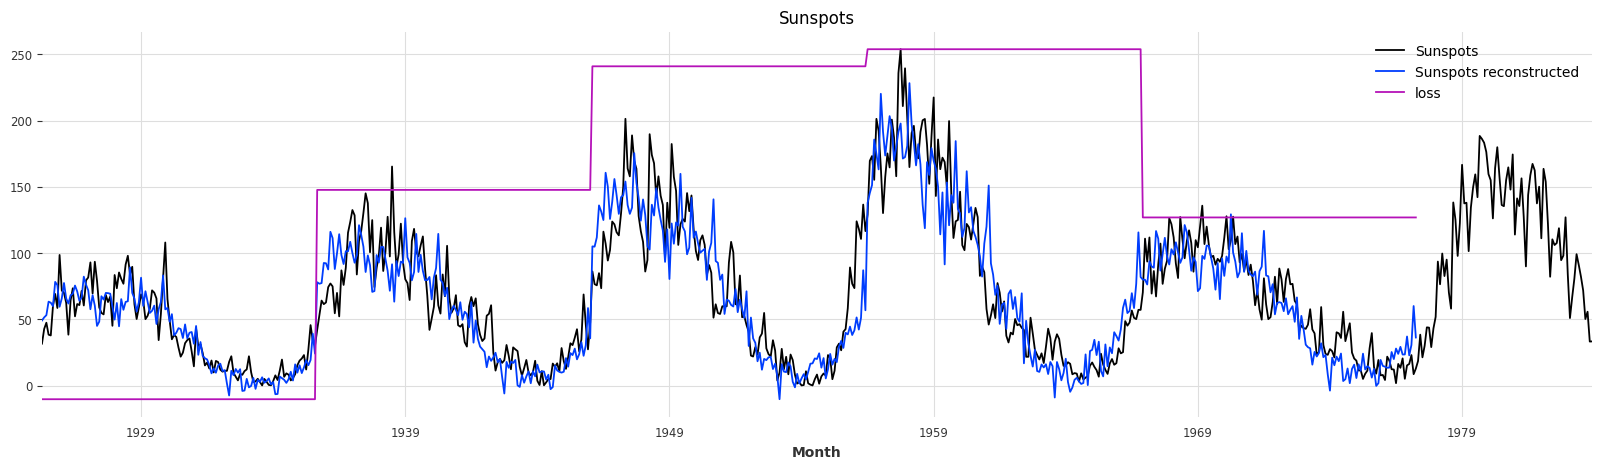

In [14]:
# normalizes a Series of values to fit into df's range
def scale_to_df(series, df):
    scale = df.max().max() - df.min().min()
    return scale * ((series - min(series)) / (max(series) - min(series))) + df.min().min()

# print one column and its reconstructed version
c = test.columns.tolist()[0]
plot_df = pd.DataFrame()
plot_df[c] = test.pd_dataframe()[c]
plot_df[f'{c} reconstructed'] = reconstructed_dataset.pd_dataframe()[c]

#let's scale the loss signal to make the display easier 
plot_df['loss']  = scale_to_df(reconstructed_dataset.pd_dataframe()['loss'], plot_df)

plot_df.plot(figsize=(20, 5))
plt.title(c)
plt.show()

## Anomaly detection
This dataset is not labelled, so we can't measure the performance of this autoencoder an anomaly detector. However, here is a way to turn the loss signal into an anomaly detector.

In [17]:
import numpy as np

threshold = 20
anomaly = np.where(reconstructed_dataset['loss'] > threshold, 150, 0)

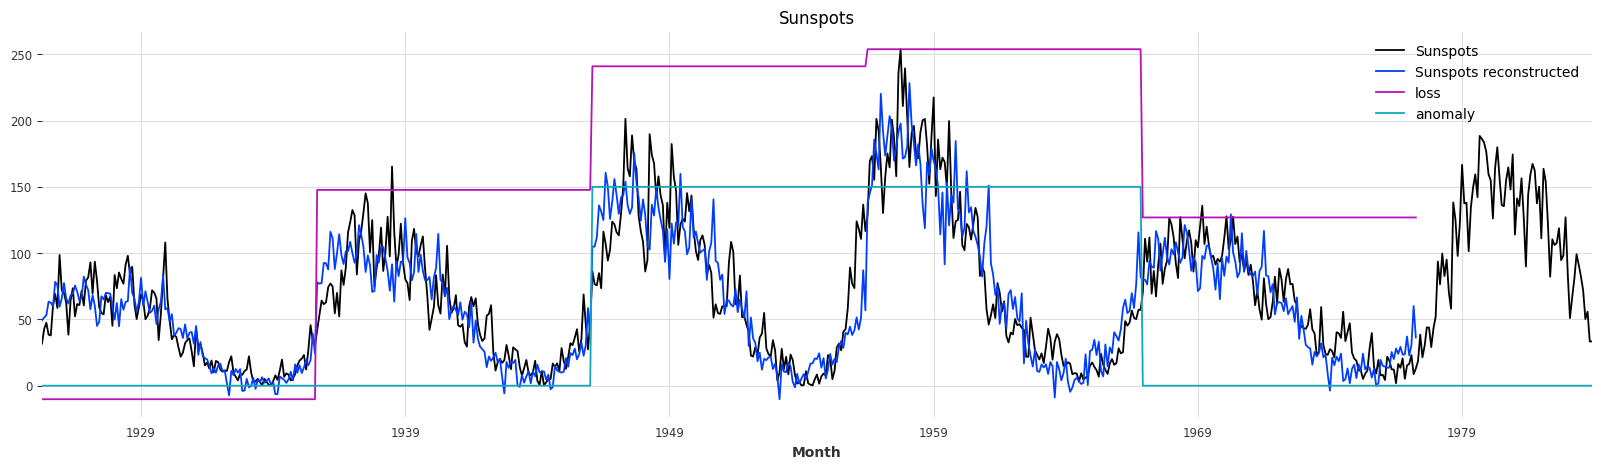

In [18]:
c = test.columns.tolist()[0]
plot_df = pd.DataFrame()
plot_df[c] = test.pd_dataframe()[c]
plot_df[f'{c} reconstructed'] = reconstructed_dataset.pd_dataframe()[c]
#let's scale the loss signal to make the display easier 
plot_df['loss']  = scale_to_df(reconstructed_dataset.pd_dataframe()['loss'], plot_df)
complete_end = len(plot_df.index) - len(anomaly)
plot_df['anomaly'] = np.append(anomaly,np.zeros(complete_end))
plot_df.plot(figsize=(20, 5))
plt.title(c)
plt.show()